In [11]:
# Global imports
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import glob

# Step2: Extract the pictures (batch)

In [12]:
# === CONFIG ===
INPUT_FOLDER = Path("list_6")  # folder with sequential images
ROI = {'x0': 107, 'y0': 689, 'x1': 1186, 'y1': 894}  # <— adjust here when needed
# ======================

# Create output directories
OUTPUT_MAIN = Path("output")
OUTPUT_SUBFOLDER = OUTPUT_MAIN / INPUT_FOLDER.name  # output/list/
OUTPUT_MAIN.mkdir(exist_ok=True)
OUTPUT_SUBFOLDER.mkdir(exist_ok=True)

print(f"Output will be saved to:")
print(f"  - Intermediate files: {OUTPUT_SUBFOLDER}")
print(f"  - Final CSV: {OUTPUT_MAIN}")

# Get all jpg files in the folder, sorted
image_files = sorted(INPUT_FOLDER.glob("*.jpg"))
print(f"\\nFound {len(image_files)} images to process")

cropped_files = []
for img_file in image_files:
    print(f"\\nProcessing: {img_file.name}")
    
    # Open and auto-rotate according to EXIF
    img = Image.open(img_file)
    img = ImageOps.exif_transpose(img)
    
    # Clamp ROI to image bounds
    w, h = img.size
    x0 = max(0, min(ROI['x0'], w))
    x1 = max(0, min(ROI['x1'], w))
    y0 = max(0, min(ROI['y0'], h))
    y1 = max(0, min(ROI['y1'], h))
    if x1 <= x0 or y1 <= y0:
        raise ValueError(f"Invalid ROI after clamping: {ROI}")
    
    # Crop and save to output subfolder
    cropped = img.crop((x0, y0, x1, y1))
    out_path = OUTPUT_SUBFOLDER / f"{img_file.stem}_crop.png"
    cropped.save(out_path, format="PNG")
    cropped_files.append(out_path)
    
    print(f"✅ Cropped: {out_path.name} | Size: {cropped.size[0]}x{cropped.size[1]}")

print(f"\\n✅ All {len(cropped_files)} images cropped successfully!")

Output will be saved to:
  - Intermediate files: output\list_6
  - Final CSV: output
\nFound 35 images to process
\nProcessing: autotrace_001.jpg
✅ Cropped: autotrace_001_crop.png | Size: 1079x205
\nProcessing: autotrace_002.jpg
✅ Cropped: autotrace_002_crop.png | Size: 1079x205
\nProcessing: autotrace_003.jpg
✅ Cropped: autotrace_003_crop.png | Size: 1079x205
\nProcessing: autotrace_004.jpg
✅ Cropped: autotrace_004_crop.png | Size: 1079x205
\nProcessing: autotrace_005.jpg
✅ Cropped: autotrace_005_crop.png | Size: 1079x205
\nProcessing: autotrace_006.jpg
✅ Cropped: autotrace_006_crop.png | Size: 1079x205
\nProcessing: autotrace_007.jpg
✅ Cropped: autotrace_007_crop.png | Size: 1079x205
\nProcessing: autotrace_008.jpg
✅ Cropped: autotrace_008_crop.png | Size: 1079x205
\nProcessing: autotrace_009.jpg
✅ Cropped: autotrace_009_crop.png | Size: 1079x205
\nProcessing: autotrace_010.jpg
✅ Cropped: autotrace_010_crop.png | Size: 1079x205
\nProcessing: autotrace_011.jpg
✅ Cropped: autotrace_011

# Step 3: Extract lines (batch)

In [13]:
# === CONFIG ===

LOWER_YELLOW = (15, 80, 80)            # yellow/gold tone
UPPER_YELLOW = (45, 255, 255)
WHITE_THRESH = 180                     # brightness threshold
# ==============

lines_files = []
for crop_file in cropped_files:
    print(f"\\nExtracting lines from: {crop_file.name}")
    
    # Load image
    bgr = cv2.imread(str(crop_file), cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Could not read {crop_file}")
    h, w = bgr.shape[:2]

    # Convert color spaces
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    
    # Detect yellow waveform
    mask_yellow = cv2.inRange(hsv, np.array(LOWER_YELLOW), np.array(UPPER_YELLOW))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    
    # Detect white baseline
    _, mask_white = cv2.threshold(gray, WHITE_THRESH, 255, cv2.THRESH_BINARY)
    horizontal = cv2.morphologyEx(mask_white, cv2.MORPH_OPEN,
                                  cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1)))
    mask_white = cv2.bitwise_and(mask_white, horizontal)
    
    # Keep the longest horizontal contour (the baseline)
    contours, _ = cv2.findContours(mask_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        biggest = max(contours, key=cv2.contourArea)
        mask_white = np.zeros_like(mask_white)
        cv2.drawContours(mask_white, [biggest], -1, 255, thickness=cv2.FILLED)
    
    # Convert to RGBA layers
    rgba_yellow = np.zeros((h, w, 4), dtype=np.uint8)
    rgba_white = np.zeros((h, w, 4), dtype=np.uint8)
    
    # Yellow: keep color where mask is set
    idx_y = mask_yellow > 0
    rgba_yellow[idx_y, :3] = bgr[idx_y][:, ::-1]  # BGR→RGB
    rgba_yellow[idx_y, 3] = 255
    
    # White line: pure white, opaque where mask is set
    rgba_white[idx_y, :] = [255, 255, 255, 0]     # start clean
    idx_w = mask_white > 0
    rgba_white[idx_w, :3] = [255, 255, 255]
    rgba_white[idx_w, 3] = 255
    
    # Combine both
    combined = np.zeros_like(rgba_white)
    combined[..., :3] = np.clip(
        rgba_yellow[..., :3].astype(np.uint16) + rgba_white[..., :3].astype(np.uint16), 0, 255
    ).astype(np.uint8)
    combined[..., 3] = np.maximum(rgba_yellow[..., 3], rgba_white[..., 3])
    
    # Save results to output subfolder
    filename = crop_file.stem.replace('_crop', '') + '_lines.png'
    out_lines = OUTPUT_SUBFOLDER / filename
    Image.fromarray(combined, "RGBA").save(out_lines)
    lines_files.append(out_lines)
    
    print(f"✅ Lines extracted: {out_lines.name}")

print(f"\\n✅ All {len(lines_files)} line images created successfully!")


\nExtracting lines from: autotrace_001_crop.png
✅ Lines extracted: autotrace_001_lines.png
\nExtracting lines from: autotrace_002_crop.png
✅ Lines extracted: autotrace_002_lines.png
\nExtracting lines from: autotrace_003_crop.png
✅ Lines extracted: autotrace_003_lines.png
\nExtracting lines from: autotrace_004_crop.png
✅ Lines extracted: autotrace_004_lines.png
\nExtracting lines from: autotrace_005_crop.png
✅ Lines extracted: autotrace_005_lines.png
\nExtracting lines from: autotrace_006_crop.png
✅ Lines extracted: autotrace_006_lines.png
\nExtracting lines from: autotrace_007_crop.png


C:\Users\Henry\AppData\Local\Temp\ipykernel_13096\752254893.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(combined, "RGBA").save(out_lines)


✅ Lines extracted: autotrace_007_lines.png
\nExtracting lines from: autotrace_008_crop.png
✅ Lines extracted: autotrace_008_lines.png
\nExtracting lines from: autotrace_009_crop.png
✅ Lines extracted: autotrace_009_lines.png
\nExtracting lines from: autotrace_010_crop.png
✅ Lines extracted: autotrace_010_lines.png
\nExtracting lines from: autotrace_011_crop.png
✅ Lines extracted: autotrace_011_lines.png
\nExtracting lines from: autotrace_012_crop.png
✅ Lines extracted: autotrace_012_lines.png
\nExtracting lines from: autotrace_013_crop.png
✅ Lines extracted: autotrace_013_lines.png
\nExtracting lines from: autotrace_014_crop.png
✅ Lines extracted: autotrace_014_lines.png
\nExtracting lines from: autotrace_015_crop.png
✅ Lines extracted: autotrace_015_lines.png
\nExtracting lines from: autotrace_016_crop.png
✅ Lines extracted: autotrace_016_lines.png
\nExtracting lines from: autotrace_017_crop.png
✅ Lines extracted: autotrace_017_lines.png
\nExtracting lines from: autotrace_018_crop.png

# Step 4: Convert to CSV and combine

In [ ]:
# --- CONFIG ---
DURATION_SEC_PER_IMAGE = 6.0           # duration of each image (seconds)
V_MAX_SCALE = 20                     # max velocity scale (distance from baseline to top border, in cm/s)
BASELINE_BAND = 3                      # pixels to remove above/below baseline
# -------------

all_dataframes = []
cumulative_time = 0.0

for idx, lines_file in enumerate(lines_files):
    print(f"\\nProcessing CSV for: {lines_file.name}")
    
    # Load image
    rgba = cv2.imread(str(lines_file), cv2.IMREAD_UNCHANGED)
    if rgba is None:
        raise FileNotFoundError(lines_file)
    
    h, w = rgba.shape[:2]
    
    if rgba.shape[2] == 4:
        alpha = rgba[..., 3]
        mask_all = (alpha > 0).astype(np.uint8) * 255
    else:
        gray = cv2.cvtColor(rgba, cv2.COLOR_BGR2GRAY)
        mask_all = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]
    
    # Detect baseline row
    row_counts = mask_all.sum(axis=1)
    y_base = int(np.argmax(row_counts))
    
    # Build waveform mask
    mask_wave = mask_all.copy()
    y0 = max(0, y_base - BASELINE_BAND)
    y1 = min(h, y_base + BASELINE_BAND + 1)
    mask_wave[y0:y1, :] = 0
    mask_wave = cv2.morphologyEx(mask_wave, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)
    
    # Find waveform pixels
    y_vals = np.full(w, np.nan, dtype=float)
    for x in range(w):
        col = mask_wave[:y_base, x]
        ys = np.where(col > 0)[0]
        if ys.size:
            y_vals[x] = ys.max()
    
    # Pixel displacement above baseline
    pix_disp = np.where(np.isfinite(y_vals), y_base - y_vals, np.nan)
    valid = np.isfinite(pix_disp)
    
    if not valid.any():
        print(f"⚠️  No waveform detected in {lines_file.name}")
        continue
    
    # Re-zero baseline
    baseline_offset_pix = np.nanpercentile(pix_disp[valid], 1.0)
    pix_disp = np.maximum(0.0, pix_disp - baseline_offset_pix)
    
    # Calculate velocity based on image height scale
    max_height_pix = float(y_base)
    px_per_cms = max_height_pix / V_MAX_SCALE
    velocity = pix_disp / (px_per_cms if px_per_cms != 0 else 1.0)
    
    # Interpolate NaNs
    v = velocity.copy()
    idx_valid = np.where(np.isfinite(v))[0]
    if idx_valid.size >= 2:
        v_interp = v.copy()
        v_interp[:idx_valid[0]] = v[idx_valid[0]]
        v_interp[idx_valid[-1] + 1:] = v[idx_valid[-1]]
        for a, b in zip(idx_valid[:-1], idx_valid[1:]):
            if b - a > 1:
                m = (v[b] - v[a]) / (b - a)
                v_interp[a+1:b] = v[a] + m * (np.arange(a+1, b) - a)
        velocity = v_interp
    velocity = np.where(velocity < 0, 0.0, velocity)
    
    # Time axis (starting from cumulative time)
    time_s = cumulative_time + (np.arange(w) / max(1, (w - 1))) * DURATION_SEC_PER_IMAGE
    
    # Create dataframe
    df = pd.DataFrame({
        "x_px": np.arange(w, dtype=int),
        "y_px": y_vals,
        "time_s": time_s,
        "velocity_cm_s": velocity,
        "image_idx": idx + 1  # image number
    })
    
    all_dataframes.append(df)
    cumulative_time += DURATION_SEC_PER_IMAGE
    
    print(f"✅ Processed | Rows: {len(df)} | Time range: {time_s[0]:.2f}-{time_s[-1]:.2f}s")

# Combine all dataframes
if all_dataframes:
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    # Save CSV to main output folder with folder name
    out_csv = OUTPUT_MAIN / f"{INPUT_FOLDER.name}_joined.csv"
    combined_df.to_csv(out_csv, index=False)
    print(f"\\n✅ Combined CSV saved: {out_csv}")
    print(f"Total rows: {len(combined_df)} | Total duration: {cumulative_time:.2f}s")
else:
    print("\\n⚠️  No data to combine")




\nProcessing CSV for: autotrace_001_lines.png
✅ Processed | Rows: 1079 | Time range: 0.00-19.00s
\nProcessing CSV for: autotrace_002_lines.png
✅ Processed | Rows: 1079 | Time range: 19.00-38.00s
\nProcessing CSV for: autotrace_003_lines.png
✅ Processed | Rows: 1079 | Time range: 38.00-57.00s
\nProcessing CSV for: autotrace_004_lines.png
✅ Processed | Rows: 1079 | Time range: 57.00-76.00s
\nProcessing CSV for: autotrace_005_lines.png
✅ Processed | Rows: 1079 | Time range: 76.00-95.00s
\nProcessing CSV for: autotrace_006_lines.png
✅ Processed | Rows: 1079 | Time range: 95.00-114.00s
\nProcessing CSV for: autotrace_007_lines.png
✅ Processed | Rows: 1079 | Time range: 114.00-133.00s
\nProcessing CSV for: autotrace_008_lines.png
✅ Processed | Rows: 1079 | Time range: 133.00-152.00s
\nProcessing CSV for: autotrace_009_lines.png
✅ Processed | Rows: 1079 | Time range: 152.00-171.00s
\nProcessing CSV for: autotrace_010_lines.png
✅ Processed | Rows: 1079 | Time range: 171.00-190.00s
\nProcessing

# Step 5: Plot the combined CSV

✅ Loaded list_6_joined.csv with 37765 rows


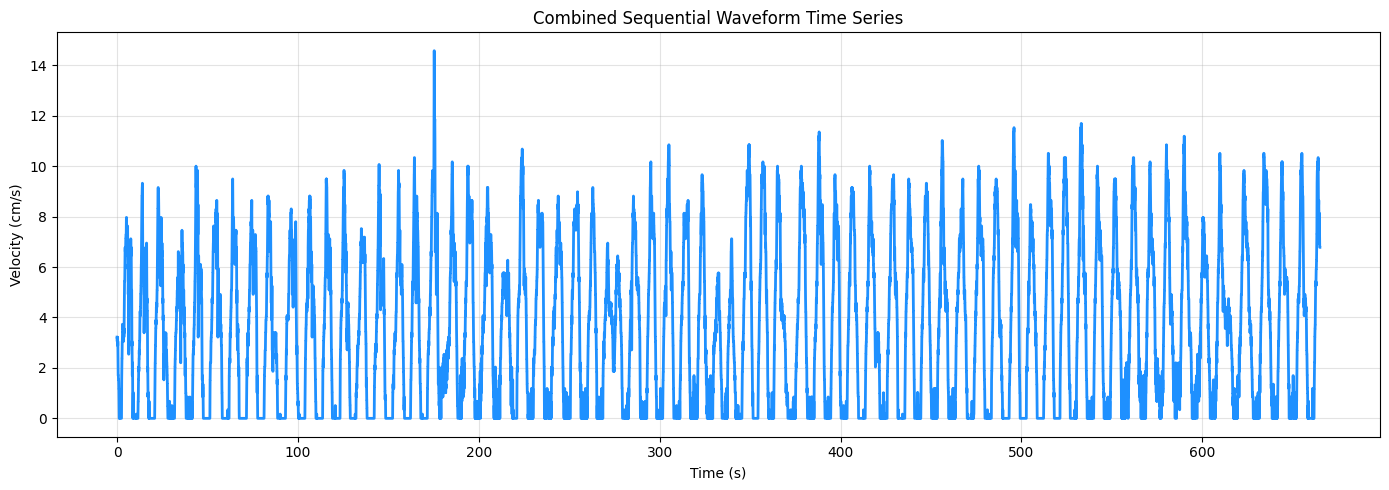

📊 Plot saved as C:\Users\Henry\Documents\MMS\Nelida\dus_pictures\output\list_6\list_6_plot.png


In [15]:
# Load the combined CSV from main output folder
csv_path = OUTPUT_MAIN / f"{INPUT_FOLDER.name}_joined.csv"
df = pd.read_csv(csv_path)
print(f"✅ Loaded {csv_path.name} with {len(df)} rows")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df["time_s"], df["velocity_cm_s"], color="dodgerblue", linewidth=2)
plt.title("Combined Sequential Waveform Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (cm/s)")
plt.grid(True, alpha=0.35)
plt.tight_layout()

# Save plot to output subfolder
out_plot = OUTPUT_SUBFOLDER / f"{INPUT_FOLDER.name}_plot.png"
plt.savefig(out_plot, dpi=150)
plt.show()

print(f"📊 Plot saved as {out_plot.resolve()}")
